# Funciones de Optimización: Mini-Batch Gradient Descent

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [1]:
from keras.datasets import reuters

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


El argumento _num_words_ indica que únicamente tendremos en cuenta las 10.000 palabras más frecuentes del conjunto de datos. Por lo tanto, el resto de palabras que sean poco frecuentes, serán descartadas y no formarán parte de las reseñas con las que entrenaremos y probaremos el algoritmo.

Tanto _train_data_ como _test_data_ se corresponden con una lista de noticias. Cada una de las noticias se corresponde con una lista de números enteros que representan el índice de una palabra. Para conocer que índice tiene cada palabra, podemos llamar al método _get_word_index()_

In [3]:
# Índices de las palabras
word_index = reuters.get_word_index()
word_index

550378/550378 [==============================] - 0s 0us/step


{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [4]:
print("Trainning data:", len(train_data))
print("Testing data:", len(test_data))

Trainning data: 8982
Testing data: 2246


In [5]:
# Primer artículo del conjunto de datos de entrenamiento
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
reversed_word_index = {v: k for k, v in word_index.items()}
' '.join([reversed_word_index.get(i - 3, f'({i})') for i in train_data[0]])

'(1) (2) (2) said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Las variables _train_labels_ y _test_labels_ se corresponden con una lista de valores que se encuentran en la siguiente lista (*):
```
"reuters":
  ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'],
```
(*) https://github.com/keras-team/keras/issues/12072

In [7]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25], dtype=int64)

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [8]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [9]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [ ]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

In [10]:
# Transformamos las etiquetas de salida en vectores
from keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

In [11]:
train_labels[0]

3

In [12]:
Y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## División del conjunto de datos 

In [13]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [14]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

In [15]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [16]:
opt_func = optimizers.SGD(learning_rate=0.01)

In [17]:
model.compile(
    optimizer=opt_func,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [ ]:
len(X_train) / 32

In [18]:
history = model.fit(
    X_train,
    Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, Y_val))

Epoch 1/30
281/281 [==============================] - 9s 29ms/step - loss: 2.3720 - accuracy: 0.5022 - precision: 0.9509 - val_loss: 1.8314 - val_accuracy: 0.5619 - val_precision: 0.9399
Epoch 2/30
281/281 [==============================] - 8s 28ms/step - loss: 1.6697 - accuracy: 0.6071 - precision: 0.9271 - val_loss: 1.6080 - val_accuracy: 0.6402 - val_precision: 0.9297
Epoch 3/30
281/281 [==============================] - 8s 29ms/step - loss: 1.4777 - accuracy: 0.6662 - precision: 0.9251 - val_loss: 1.4812 - val_accuracy: 0.6785 - val_precision: 0.9211
Epoch 4/30
281/281 [==============================] - 8s 27ms/step - loss: 1.3475 - accuracy: 0.6996 - precision: 0.9260 - val_loss: 1.3874 - val_accuracy: 0.6928 - val_precision: 0.9085
Epoch 5/30
281/281 [==============================] - 8s 30ms/step - loss: 1.2478 - accuracy: 0.7214 - precision: 0.9235 - val_loss: 1.3173 - val_accuracy: 0.7186 - val_precision: 0.9075
Epoch 6/30
281/281 [==============================] - 8s 29ms/ste

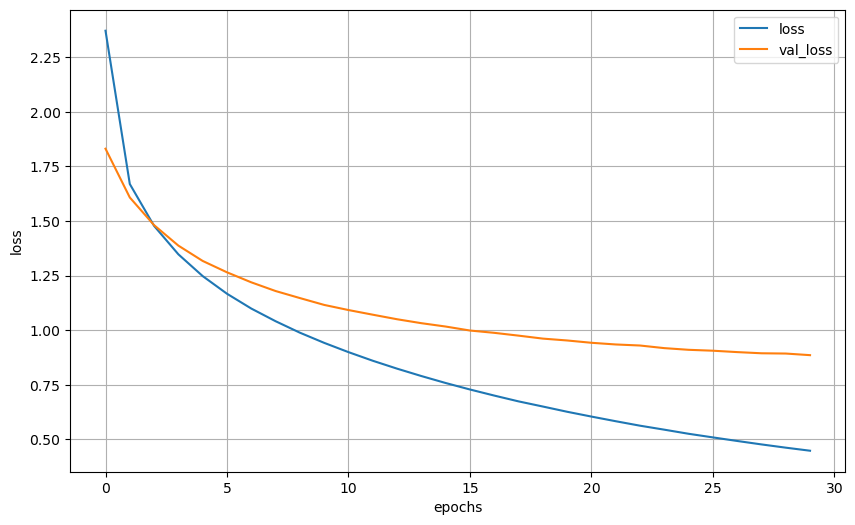

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

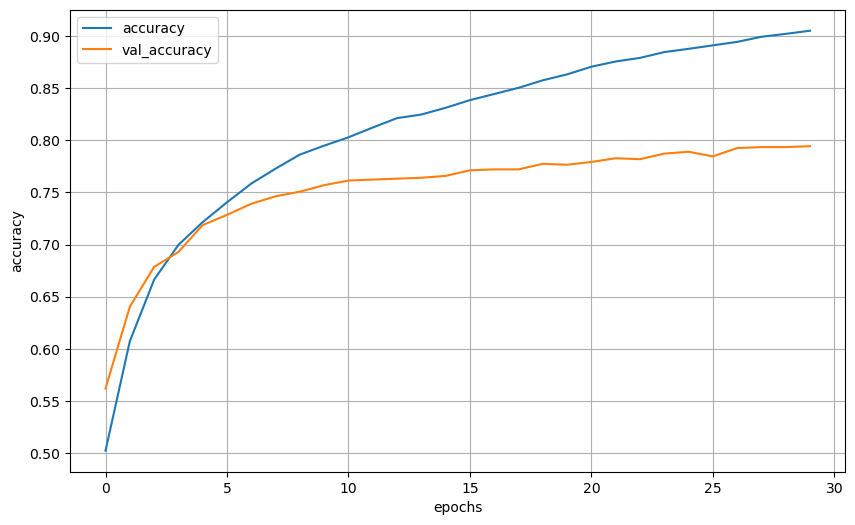

In [20]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### Predicción con el subconjunto de datos de pruebas

In [21]:
error, accuracy, precision = model.evaluate(X_test, Y_test)

36/36 [==============================] - 0s 10ms/step - loss: 0.8681 - accuracy: 0.7970 - precision: 0.8874


In [22]:
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

Error:  0.8680524826049805
Accuracy:  0.796972393989563
Precision:  0.8873873949050903
